In [33]:
import numpy as np;
import time;

In [34]:
import matplotlib.pyplot as plt;
%matplotlib inline

In [35]:
from RBComb.SerialBridge import *
from RBComb.RBComb576 import *
from RBComb.LaserInterface import *
from RBComb.Helper.BoardPinout import *
from RBComb.Helper.BoardUnits import *;
from RBComb.Helper.FunctionInterpolator import *

In [36]:
# This document shows how 2 signal generators with positive/negative amplitude can be combined
# to make a single signal generator with arbitrary phase.
# This is done by phase-shifting one of the generators by 90 degrees so it acts as the imaginary
# part of the amplitude.

In [37]:
# Construct bridge:
currentBridge = SerialBridge('/dev/tty.usbserial-FT3J6M59B', True, 300);

# Note: the correct baud rate is 5'000'000 but it is not supported in Mac OS X
# The solution is to modify the serial port driver so it aliases ("pretends") to be working at a standard
# rate of 300, but in reality it works at 5000000. This is done by modifying /Library/Extensions/FTDIUSBSerialDriver.kext
# following the guide https://www.ftdichip.com/Support/Documents/TechnicalNotes/TN_105%20Adding%20Support%20for%20New%20FTDI%20Devices%20to%20Mac%20Driver.pdf
# And subsequently disabling the "trusted platform" features of mac since it would no longer accept the modified extension

In [51]:
# Make sure clock is off
currentBridge.disableClock();

In [52]:
# Construct RBComb576
rbComb = RBComb576(currentBridge);

In [53]:
# Construct laser
laser = LaserInterface(currentBridge);

In [54]:
# Construct helper objects:
pinout = BoardPinout();
units = BoardUnits();

In [55]:
# Make sure we don't have garbage from previous runs in the serial port read buffer
currentBridge.flushInput()

In [1]:
# Read displacement from laser to see if everything is fine
currentBridge.selectLaser();
laserDisplacement = laser.requestDisplacement(axis=1)
print(f'{laserDisplacement/1e9} [mm]')

NameError: name 'currentBridge' is not defined

In [57]:
currentBridge.selectAllBoards()

In [58]:
# We use the interpolator to raise the signal to V/2 as the output cannot take negative values
interpolator = FunctionInterpolator();
constantFunction = interpolator.getConstantFunction(0.5)

# Upload offset function to the device (Takes 10 seconds, do only once per "session")
for i in range(576):
    rbComb.setTaylorCoefficients(i, False, constantFunction);
    

# Ramp up (won't take effect until turning on the clock)
rbComb.outputRampUp();

In [46]:
currentBridge.enableClock();
time.sleep(4.0);
currentBridge.disableClock();

In [104]:
excitationFrequency = 35000;
excitationPhase = 0;
excitationAmplitude = 1.25;

In [105]:
currentBridge.disableClock();
currentBridge.selectAllBoards()
rbComb.setCurrentState([1,0,0,0,0]);
rbComb.setGain(True);

# Configure phases:
rbComb.setPhase(0, units.convertDegreesPhaseToInteger(excitationPhase))

# Configure frequencies:
rbComb.setFrequency(0, units.convertFrequencyHzToInteger(excitationFrequency))

# Make sure that the generators don't sweep
for i in range(4):
    rbComb.setSweepFrequencyStep(i,0);

# Configure amplitudes: 
for i in range(576):
    rbComb.setAmplitude(0,i,units.convertNormalizedAmplitudeToInteger(excitationAmplitude/2.5));
    rbComb.setAmplitude(1,i,0);
    rbComb.setAmplitude(2,i,0);
    rbComb.setAmplitude(3,i,0);

In [106]:
currentBridge.selectLaser();
laser.scheduleAcquisition(axis=1, delay=50000)
currentBridge.selectAllBoards();
currentBridge.enableClock();
currentBridge.selectLaser();
while not laser.isAcquisitionFinished():
    print('Acquisition not yet finished');
    time.sleep(0.1);
print('Acquisition finished!')
currentBridge.disableClock();

Acquisition not yet finished
Acquisition not yet finished
Acquisition not yet finished
Acquisition not yet finished
Acquisition finished!


In [107]:
currentBridge.selectLaser();
data = laser.requestTimeTrace()

In [108]:
data

array([[2.50000000e+01, 2.36244445e+10],
       [2.57000000e+02, 2.36244419e+10],
       [4.89000000e+02, 2.36244406e+10],
       ...,
       [7.60157900e+06, 2.36244334e+10],
       [7.60181100e+06, 2.36244349e+10],
       [7.60204300e+06, 2.36244360e+10]])

Text(0,0.5,'Displacement (nm)')

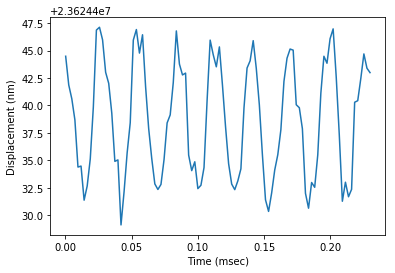

In [109]:
rangeStart = 0
rangeEnd = 100
plt.plot(data[rangeStart:rangeEnd,0]/1e5, data[rangeStart:rangeEnd,1]/1e3)
plt.xlabel('Time (msec)')
plt.ylabel('Displacement (nm)')

(0, 100)

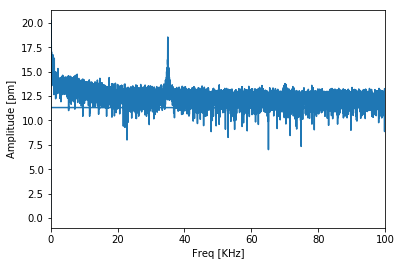

In [110]:
noMean = data[:,1] - np.average(data[:,1]);
freqs = np.fft.fftfreq(len(noMean), 1e-8*(data[50,0]-data[0,0])/50.0)/1e3;
amps = np.abs(np.fft.fft(noMean));
plt.plot(freqs, np.log(1+amps))
plt.xlabel('Freq [KHz]');
plt.ylabel('Amplitude [pm]');
plt.xlim([0,100])

In [31]:
# Close the serial port:
currentBridge.closeConnection()

(32768, 2)